# 1. Tensorflow Hub
- https://tfhub.dev/
- 모델을 조정 및 배포 가능한 학습된 머신러닝 모델의 저장소
- 단 몇줄의 코드만으로 CNN과 BERT와 같은 학습된 모델을 재사용할 수 있음

In [ ]:
# https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
# feature_vector는 정답이 없는 분류
# classification은 정답이 있는 분류

In [1]:
# !pip install tensorflow_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 2.2 MB/s eta 0:00:004.4 MB/s eta 0:00:01


In [1]:
from tensorflow import keras
from tensorflow.keras import activations
from tensorflow.keras.applications import EfficientNetB0


import pandas as pd
import numpy as np
import tensorflow as tf
import math
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [2]:
model = tf.keras.Sequential([
    hub.KerasLayer('https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build([None, 256, 256, 3])

adam = keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer = adam,
    loss = 'binary_crossentropy',
    metrics = 'accuracy'
)

model.summary()

OSError: SavedModel file does not exist at: /var/folders/8l/kz0_v8kd0jz1m3wsxv26gzy00000gn/T/tfhub_modules/053ef6b4dfb0b2a075eb96fcb2f1f7600e6b8e87/{saved_model.pbtxt|saved_model.pb}

In [15]:
input_shape = (256, 256, 3)
model = get_model(input_shape)

adam = keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer = adam,
    loss = 'binary_crossentropy',
    metrics = 'accuracy'
)

NameError: name 'get_model' is not defined

In [6]:
class Augmentation :
    def __init__(self, size, mode='train') :
        if mode == 'train' :
            self.transform = A.Compose([
                # 수평
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1*size),
                    max_width=int(0.1*size)
                ),
                A.RandomBrightnessContrast(p=0.2)
            ])
            
    def __call__(self, **kwargs) : # **kwargs : 매개변수의 개수에 상관없이 Dictionary로 바꿔준다.
        if self.transform :
            augmented = self.transform(**kwargs)
            img = augmented['image']
            
            return img

In [7]:
class DataGenerator(keras.utils.Sequence) :
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True) :
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train' :
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val' :
            self.df = self.df[self.df['fold'] == self.fold]
            
            
        #https://github.com/tensorflow/models/issues/3134
        
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
            
        self.on_epoch_end()
    
    # sample() : 전체 row(행)에서 몇 %의 데이터를 return 할 것인지 설정
    # frac : 데이터프레임으로 부터 특정 비율로 무작위 표본 추출을 하고 싶으면 0 ~ 1 사이의 부동소수점을 입력
    # reset_index() : drop = True 옵션을 설정하면 인덱스 열을 보통의 자료열로 설정하는 것이 아니라 버림
    def on_epoch_end(self) :
        if self.shuffle :
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    # len()
    def __len__(self) :
        return math.ceil(len(self.df) / self.batch_size) # ceil 올림
    
    # 클래스의 인덱스 접근할 떄 자동으로 호출되는 메소드
    def __getitem__(self, idx) :
        start = idx * self.batch_size
        end = (idx+1) * self.batch_size
        data = self.df.iloc[start:end]
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
    
    # batch 만큼의 데이터들을 가져온다
    def get_data(self, data) :
        batch_x = []
        batch_y = []
        
        # 데이터 프레임에서 row의 개수만큼 반복
        # 튜플로 리턴(index, 행정보(Series))
        
        for _, r in data.iterrows() :
            file_name = r['file_name']
            image = cv2.imread(f'1_data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            
            if self.mode == 'train' :
                image = image.astype('uint8')
                image = self.transform(image=image)
            
            image = image.astype('float32')
            image = image/255.
            
            label = int(r['species']) -1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y

In [8]:
csv_path = './1_data/kfolds.csv'

#def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True)
train_generator = DataGenerator(
    batch_size = 64,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 64,
    csv_path = csv_path,
    fold = 1,
    image_size = 256,
    mode = 'val',
    shuffle = True
)

In [10]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    verbose = 1
)

Epoch 1/10


2022-06-07 20:19:45.114191: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-07 20:19:49.098414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.5942

2022-06-07 20:20:12.751424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 33s 278ms/step - loss: 0.6660 - accuracy: 0.5942 - val_loss: 0.5731 - val_accuracy: 0.7745
Epoch 2/10
92/92 [==============================] - 21s 229ms/step - loss: 0.4856 - accuracy: 0.8791 - val_loss: 0.4324 - val_accuracy: 0.9298
Epoch 3/10
92/92 [==============================] - 21s 233ms/step - loss: 0.3760 - accuracy: 0.9442 - val_loss: 0.3408 - val_accuracy: 0.9666
Epoch 4/10
92/92 [==============================] - 22s 243ms/step - loss: 0.3036 - accuracy: 0.9600 - val_loss: 0.2777 - val_accuracy: 0.9782
Epoch 5/10
92/92 [==============================] - 22s 237ms/step - loss: 0.2541 - accuracy: 0.9690 - val_loss: 0.2331 - val_accuracy: 0.9843
Epoch 6/10
92/92 [==============================] - 22s 238ms/step - loss: 0.2218 - accuracy: 0.9702 - val_loss: 0.2001 - val_accuracy: 0.9864
Epoch 7/10
92/92 [==============================] - 22s 239ms/step - loss: 0.1939 - accuracy: 0.9711 - val_loss: 0.1744 - val_accuracy: 0.9877
Epoch 8/10

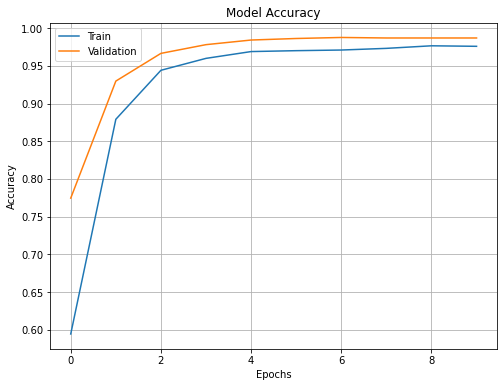

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='best')
plt.grid()
plt.show()